In [2]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from lec_utils import * 
# from save_data import * 

# Your Title Here

**Name(s)**: Pheobe Yi and Omkar nayak 

**Website Link**: In progress 

## Step 1: Introduction

In [ ]:
base_path = Path("/Users/yipho/eecs398/portfolio/allyears")
output_path = Path("/Users/yipho/eecs398/portfolio/raw_data") 
output_path.mkdir(parents=True, exist_ok=True) 

years_to_process = range(2000, 2024)

def rename_case_id_to_respondent_id(df):
    if "RESPONDENT_ID" in df.columns and "CASEID" not in df.columns:
        df.rename(columns={"RESPONDENT_ID": "CASEID"}, inplace=True)
    return df

def load_and_save_icpsr_data(base_path, output_path, years_to_process):
    for year in years_to_process:
        icpsr_folders = list(base_path.glob(f"ICPSR_*{year}")) 
        print(icpsr_folders)

        merged_data= []  

        for folder in icpsr_folders:
            study_number = folder.name.split("_")[1].split("-")[0]  

            form1_path = folder / f"DS0001/{study_number}-0001-Data.dta"
            form6_path = folder / f"DS0006/{study_number}-0006-Data.dta"

            # Load and merge Form 1 and Form 6 if both exist
            if form1_path.exists() and form6_path.exists():
                print(f"form 1 and form 2 exists for {year}")
                try:
                    # Load Form 1
                    df1 = pd.read_stata(form1_path)
                    print(f"form 1 shape: {df1.shape}")
                    df1 = rename_case_id_to_respondent_id(df1)

                    # Load Form 6
                    df6 = pd.read_stata(form6_path)
                    print(f"form 6 shape: {df6.shape}")
                    df6 = rename_case_id_to_respondent_id(df6)

  
                    if "RESPONDENT_ID" in df1.columns and "RESPONDENT_ID" in df6.columns:
                        df_merged = df1.merge(df6, on="RESPONDENT_ID", how="inner")
                        print(f"merged data shape:{df_merged.shape}")


                        df_merged["Year"] = year

                        merged_data.append(df_merged)
                    else:
                        print(f"'RESPONDENT_ID' column missing in Form 1 or Form 6 for year {year}. Skipping merge.")
                except Exception as e:
                    print(f"error processing form 1 and form 6 for {year}: {e}")
            else:
                if not form1_path.exists():
                    print(f"form 1 data not found for year {year}: {form1_path}")
                if not form6_path.exists():
                    print(f"form 6 data not found for year {year}: {form6_path}")

        if merged_data:
            year_df = pd.concat(merged_data, axis=0)  
            output_file = output_path / f"ICPSR_data_{year}.csv"
            year_df.to_csv(output_file, index=False)
            print(f"saved merged data for year {year} to {output_file}")
        else:
            print(f"no merged data found for year {year}.")

load_and_save_icpsr_data(base_path, output_path, years_to_process)
# god bless Kerby Shedden 

Processing year 2012...
[PosixPath('/Users/yipho/eecs398/portfolio/allyears/ICPSR_34861-2012')]
Found Form 1 and Form 6 data for year 2012.
Loaded Form 1 with shape: (14343, 163)
Loaded Form 6 with shape: (2401, 309)
Merged data shape: (2401, 471)
Saved merged data for year 2012 to /Users/yipho/eecs398/portfolio/raw_data/ICPSR_data_2012.csv


## Step 2: Data Cleaning and Exploratory Data Analysis

In [26]:
base_path = Path("/Users/yipho/eecs398/portfolio/raw_data")
output_path = Path("/Users/yipho/eecs398/portfolio/processed_data") 
output_path.mkdir(parents=True, exist_ok=True)

variable_mapping = {
    "POL_BELIEFS": {
        (2000, 2023): "V5167",
    },
    "SEX" : {
        (2000, 2023): "V2150",
    },
    "NUM_SIBS": {
        (2000, 2023): "V49",
    }, 
    "BR_SR_inhouse": {
        (2000, 2011): "V157",
        (2012, 2023): "V2157",
    },
    "FATHR_PRES": {
        (2000, 2011): "V155",
        (2012, 2018): "V7206",
        (2019, 2023): "V5155",
    },
    "MOTHR_PRES": {
        (2000, 2011): "V156",
        (2012, 2018): "V7207",
        (2019, 2023): "V5156",
    },
    "LONELY": {
        (2000, 2023): "V5313", 
    },
    "WISH_MORE_FRNDS": {
        (2000, 2023): "V5321",  
    },
    "USLLY_FRNDS": {
        (2000, 2023): "V5324",  
    },
}

def get_variable_for_year(variable_name, year):
    for year_range, var in variable_mapping[variable_name].items():
        if year_range[0] <= year <= year_range[1]:
            return var
    return None

def rename_variables(df, year):
    renamed_columns = {}

    for logic_name, year_mapping in variable_mapping.items():
        column_name = get_variable_for_year(logic_name, year)
        if column_name and column_name in df.columns:
            renamed_columns[column_name] = logic_name

    df = df.rename(columns=renamed_columns)
    print(f"Renamed columns for year {year}: {renamed_columns}")
    return df

def clean_and_process_data(df, year):
    df = rename_variables(df, year)

    cols_interest = [
        "RESPONDENT_ID",
        "V1_x", 
        "SEX",  
        "POL_BELIEFS",  
        "NUM_SIBS", 
        "BR_SR_inhouse", 
        "FATHR_PRES",  
        "MOTHR_PRES",  
        "LONELY",  
        "WISH_MORE_FRNDS",  
        "USLLY_FRNDS", 
    ]

    cols_interest = [col for col in cols_interest if col in df.columns]  
    dfmain = df[cols_interest]

    # Clean variables where needed
    cols_clean = ["NUM_SIBS", "SEX", "POL_BELIEFS", "BR_SR_inhouse", "FATHR_PRES", "MOTHR_PRES", "LONELY", "WISH_MORE_FRNDS", "USLLY_FRNDS"]
    cols_clean = [col for col in cols_clean if col in df.columns]


    def extract_number(column):
        pattern = r".+:\s*\((\d+)\)"
        return column.apply(lambda x: int(re.match(pattern, str(x)).group(1)) if re.match(pattern, str(x)) else None)
    
    for col in cols_clean:
        dfmain[col] = extract_number(dfmain[col])
    
    # Drop invalid values for POL_BELIEFS (V5167)
    if "POL_BELIEFS" in dfmain.columns:
        dfmain = dfmain[dfmain["POL_BELIEFS"].isin([6, 8, -9]) == False]
        dfmain = dfmain.dropna(subset=["POL_BELIEFS"])
        # Rescale to start from 0
        dfmain["POL_BELIEFS"] = dfmain["POL_BELIEFS"] - 1  
    
    # Drop invalid values for SEX (V2150)
    if "SEX" in dfmain.columns:
        dfmain = dfmain[dfmain["SEX"].isin([-9, 3, 4]) == False]
        dfmain = dfmain.dropna(subset=["SEX"])
         # 0 for male, 1 for female
        dfmain["SEX"] = dfmain["SEX"] - 1 

    return dfmain

# Process each CSV file based on year
def process_raw_data(base_path, output_path):
    for csv_file in base_path.glob("ICPSR_data_2014.csv"):
        try:
            # Extract year from file name
            year = int(csv_file.stem.split("_")[-1])
            print(f"Processing file for year {year}: {csv_file}")

            # Load data
            df = pd.read_csv(csv_file)
            print(f"Loaded data with shape: {df.shape}")

            # Process data
            df_processed = clean_and_process_data(df, year)
            print(f"Processed data shape: {df_processed.shape}")

            # Save processed data
            output_file = output_path / f"data_{year}.csv"
            df_processed.to_csv(output_file, index=False)
            print(f"Saved processed data for year {year} to {output_file}")

        except Exception as e:
            print(f"Error processing file {csv_file}: {e}")


process_raw_data(base_path, output_path)

,RESPONDENT_ID,V1_x,SEX,POL_BELIEFS,...,MOTHR_PRES,LONELY,WISH_MORE_FRNDS,USLLY_FRNDS
0,50001,2023,1.0,3.0,...,1.0,5.0,5.0,4.0
1,50002,2023,1.0,4.0,...,1.0,5.0,4.0,4.0
2,50005,2023,0.0,0.0,...,1.0,3.0,1.0,1.0
3,50006,2023,1.0,2.0,...,1.0,4.0,3.0,4.0
4,50007,2023,0.0,0.0,...,1.0,5.0,1.0,5.0


In [4]:
dfcat = pd.read_csv("raw_data/ICPSR_data_2023.csv")

In [5]:
cols_interest = ['RESPONDENT_ID', 'V1_x', 'V2150','V49_x', 'V2167', 'V2157', 'V2155', 'V2156', 'V5313', 'V5321']
dfmain = dfcat[cols_interest]
dfmain.head()

,RESPONDENT_ID,V1_x,V2150,V49_x,...,V2155,V2156,V5313,V5321
0,50001,2023,FEMALE:(2),THREE+:(3),...,MARKED:(1),MARKED:(1),AGREE:(5),AGREE:(5)
1,50002,2023,FEMALE:(2),THREE+:(3),...,NT MARKD:(0),MARKED:(1),AGREE:(5),MOST AGR:(4)
2,50003,2023,MALE:(1),TWO:(2),...,NT MARKD:(0),MARKED:(1),AGREE:(5),AGREE:(5)
3,50004,2023,MALE:(1),TWO:(2),...,MARKED:(1),MARKED:(1),MOST AGR:(4),DISAGREE:(1)
4,50005,2023,MALE:(1),THREE+:(3),...,MARKED:(1),MARKED:(1),NEITHER:(3),DISAGREE:(1)


In [16]:
cols_clean = ['V49_x','V2150', 'V2167', 'V2157', 'V2155', 'V2156', 'V5313', 'V5321']

def extract_number(column):
    pattern = r".+:\s*\((\d+)\)"
    return column.apply(lambda x: int(re.match(pattern, str(x)).group(1)) if re.match(pattern, str(x)) else None)

In [17]:
for col in cols_clean:
    dfmain[col] = extract_number(dfcat[col])

dfmain.head()

,RESPONDENT_ID,V1_x,V2150,V49_x,...,V2155,V2156,V5313,V5321
0,50001,2020,1.0,NaN,...,1.0,1.0,2.0,NaN
1,50002,2020,NaN,NaN,...,NaN,NaN,NaN,NaN
2,50003,2020,NaN,NaN,...,NaN,NaN,NaN,NaN
3,50004,2020,1.0,NaN,...,1.0,1.0,NaN,NaN
4,50005,2020,2.0,1.0,...,0.0,1.0,5.0,1.0


In [18]:
#drop 6,8,-9 for 2167 Pol leaning 
dfmain = dfmain[dfmain['V2167'] != 6]
dfmain = dfmain[dfmain['V2167'] != 8]
dfmain = dfmain[dfmain['V2167'] != -9]
#drop nan
dfmain = dfmain.dropna(subset=['V2167'])
#rescale and regularize 
dfmain['V2167'] = dfmain['V2167'] - 1

In [19]:
# for sex, drop -9, 3 and 4 (missing other and refused to answer)
dfmain = dfmain[dfmain['V2150'] != -9]
dfmain = dfmain[dfmain['V2150'] != 4]
dfmain = dfmain[dfmain['V2150'] != 3]

dfmain = dfmain.dropna(subset=['V2150'])

dfmain['V2150'] = dfmain['V2150'] - 1
# 0 for male, 1 for female now 
dfmain['V2150'].value_counts()

V2150
1.0    211
0.0    140
Name: count, dtype: int64

In [20]:
pol_blfs = ["Very Conservative", "Conservative", "Moderate", "Liberal", "Very Liberal"]
counts = dfmain['V2167'].value_counts().sort_index()


colors = ['red', 'pink', 'darkgray', 'lightblue', 'blue']


fig = px.bar(
    x=counts.index,
    y=counts.values,
    title='Political Beliefs Distribution',
    labels={'x': 'Political Beliefs', 'y': 'Count'},
    color=counts.index, 
    color_discrete_sequence=colors  
)

# Update x-axis labels
fig.update_layout(
    xaxis_title="Political Beliefs",
    yaxis_title="Count",
    xaxis=dict(
        tickmode='array',
        tickvals=counts.index,
        ticktext=pol_blfs
    )
)
# Show the chart
fig.show()


In [21]:
fig.write_html("/Users/yipho/eecs398/portfolio/plot1PB.html",include_plotlyjs='cdn')

In [ ]:
print("fuck this man why isn't it working")

In [45]:
dfscat = pd.read_csv("raw_data/ICPSR_data_2023.csv")

## SECOND PLOT, BIVAR ANALYSIS 1 

In [46]:
#set up a scatter plot 
dfscat["V5313"] = (dfscat["V5313"]).replace({'NEITHER:(3)':3,'MOST AGR:(4)':4
        ,'MOST DIS:(2)':2,'AGREE:(5)':5,'DISAGREE:(1)':1,'MISSING:(-9)':-9})
dfscat["V5167"] = (dfscat["V5167"]).replace({
    'NONE/DK:(8)':8,'MODERATE:(3)':3, 'LIBERAL:(4)':4, 'CONSERV:(2)':2, 'MISSING:(-9)':-9,
    'VRY LIB:(5)':5,'VRY CONS:(1)':1,'RADICAL:(6)':6
    })

dfscat.drop(dfscat[dfscat["V5167"] == -9].index, inplace=True)
dfscat.drop(dfscat[dfscat["V5167"] == 8].index, inplace=True)
dfscat.drop(dfscat[dfscat["V5167"] == 6].index, inplace=True)
dfscat.drop(dfscat[dfscat["V5313"] == -9].index, inplace=True)

newod = pd.DataFrame()
newod["Alone"] = dfscat["V5313"]
newod["PolBel"] = dfscat["V5167"]

pivot_table = pd.crosstab(newod["Alone"], newod["PolBel"])


In [11]:
fig = px.density_heatmap(
    dfscat,
    x='V5167',
    y='V5313',
    color_continuous_scale='Viridis',
    title="Heatmap Example"
)
fig.show()
fig.write_html("/Users/macbook/Desktop/EECS389/398_mtf/plot2HM.html", include_plotlyjs='cdn')


## THIRD PLOT, BIVAR ANALYSIS 2 

In [50]:
dfscat["V5324"] = dfscat["V5324"].replace({'AGREE:(5)':'AGREE:(5)',"MOST AGR:(4)":'AGREE:(5)',
"NEITHER:(3)":3,"MOST DIS:(2)":2,"DISAGREE:(1)":1,"MISSING:(-9)":-9})
dfscat.drop(dfscat[dfscat["V5324"] == -9].index, inplace=True)


dfscat["V2150"] = dfscat["V2150"].replace({'FEMALE:(2)':"Female","MALE:(1)":"Male",
"PREFER NOT ANSWER:(4)":4,"MISSING:(-9)":-9,"OTHER:(3)":3})
dfscat.drop(dfscat[dfscat["V2150"] == 4].index, inplace=True)
dfscat.drop(dfscat[dfscat["V2150"] == -9].index, inplace=True)
dfscat.drop(dfscat[dfscat["V2150"] == 3].index, inplace=True)


In [51]:
px.box(dfscat, x="V2150", y="V5324", title="Sex and Social Networks Size (Friends)",
       labels={"V2150":"Sex", "V5324":"Cosistent group of friends?"})

In [53]:
fig.write_html("/Users/macbook/Desktop/EECS389/398_mtf/plot3BS.html", include_plotlyjs='cdn')

## Step 3: Framing a Prediction Problem

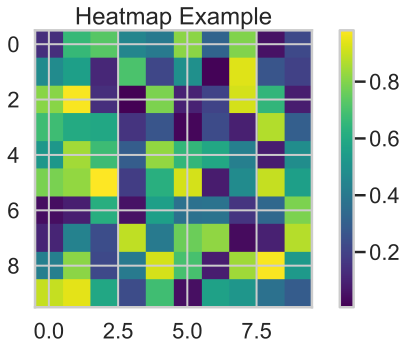

## Step 4: Baseline Model

In [ ]:
# TODO

## Step 5: Final Model

In [ ]:
# TODO